Libraries
* pandas: used this library for data manipulation and analysis
* numpy: library for numerical and mathematical operations
* matplotlib: imported the pyplot module from the matplotlib library, which is a widely-used library for creating static, animated, or interactive visualizations
* seaborn: It is a data visualization library built on top of matplotlib. It provides a high-level interface for creating aesthetically pleasing and informative statistical graphics.
* 'fivethirtyeight' style is used to set background style of Matplotlib plots
* We import wordcloud for EDA
* We import re, string, nltk, spacy for tweets cleaning
* We import sklearn for machine learning and metrics

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# For data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# setting up the background style for the plots
plt.style.use('fivethirtyeight')

# For data manuplation and cleaning
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer

import spacy
nlp = spacy.load('en_core_web_sm')

# Feature Extraction Techniques
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

## Read Dataset

In [ ]:
train_df = pd.read_csv('/content/twitter_sentiments.csv')
print('Train dataset shape: ', train_df.shape)
print('Train dataset columns: ', train_df.columns)

Train dataset shape:  (31962, 3)
Train dataset columns:  Index(['id', 'label', 'tweet'], dtype='object')


## Selecting necessary features from train data

In [ ]:
train_df = train_df[['label','tweet']]

### Exploratory Data Analysis

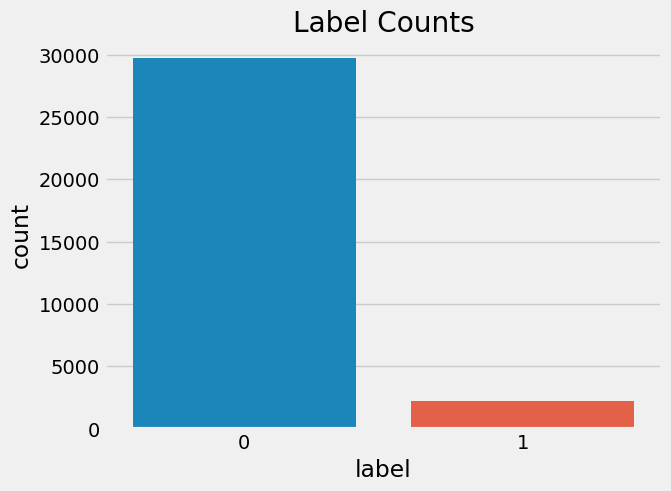

In [ ]:
#Labbel Categories count
sns.countplot(x= train_df['label'])
plt.title('Label Counts')
plt.show()

* by the above plot we can understand that in our data most of the data labelled as 0 with means positive sentiment, on the other hand label = 1 means negative sentiment.

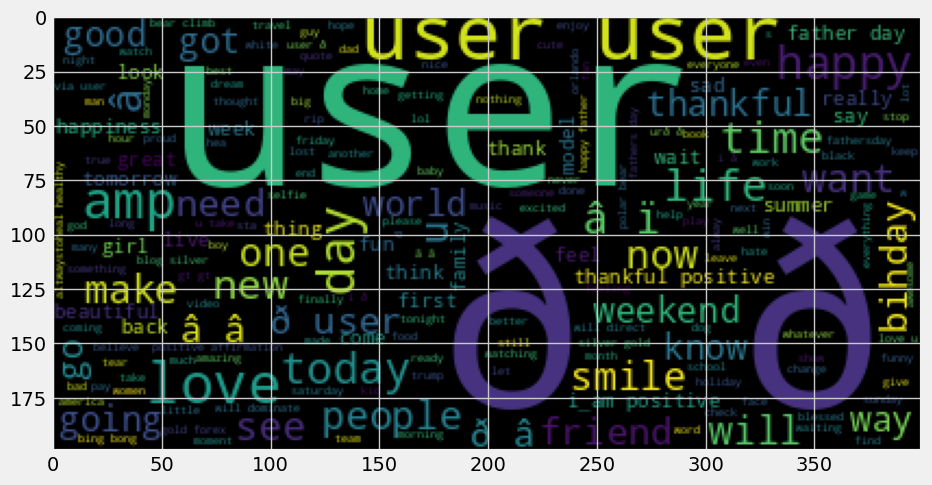

In [ ]:
from wordcloud import WordCloud

sentences = train_df['tweet'].tolist()
sentences_ss = " ".join(sentences)

plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(sentences_ss))

* With the help of wordcloud we can find most repeated words easily from the whole dataset. By the above image we can come to a conclusion that in our data 'user' is the word which repeated more number of times. And we have some unknown symbols also in our data. So, befor proceeding with modelling, we should first clean the data.

### Word Frequency Analysis

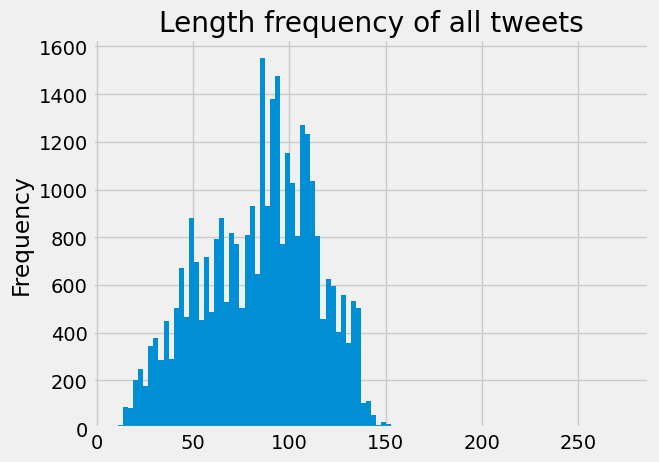

In [ ]:
train_df['tweet'].apply(len).plot(bins=100, kind = 'hist')
plt.title('Length frequency of all tweets')
plt.show()

* The above histogram shows us the length frequency of the each tweet from the dataset

In [ ]:
train_df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

## RandomOverSampler for data balance technique

In [ ]:
import pandas as pd

# Separate the data into positive (label 1) and negative (label 0) samples
positive_samples = train_df[train_df['label'] == 1]
negative_samples = train_df[train_df['label'] == 0]

# Sample 10,000 unique positive and 10,000 unique negative samples
balanced_positive_samples = positive_samples.sample(n=10000, random_state=42, replace=True)
balanced_negative_samples = negative_samples.sample(n=10000, random_state=42, replace=True)

# Concatenate the balanced samples
balanced_df = pd.concat([balanced_positive_samples, balanced_negative_samples])

# Shuffle the DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Now 'balanced_df' contains your balanced dataset with 20,000 unique samples


In [ ]:
balanced_df.label.value_counts()

0    10000
1    10000
Name: label, dtype: int64

### Spliting dataset into input(X) and target(y)

In [ ]:
X = balanced_df.iloc[:,[1]]
y = balanced_df.iloc[:,0]

### Preprocessing & Cleaning of Data

In this cleaning process we are going to do the following steps
* removing @usernames
* converting all words into lowercase
* removing numbers
* removing punctuations
* removing URLs
* tokanize each tweet -> Tokenization is a way of separating a piece of text (sentence) into smaller units called tokens.
* remove while spaces
* remove stop words -> “stop words” usually refers to the most common words in a language, like is, are, the, a, an, and so on
* removing non alphabetics tokens
* performing lemmatization -> remove inflectional endings only i.e. running, runner == run

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
# Remove @usernames
X['tweet'] = X['tweet'].map(lambda x: re.sub('@\S+', ' ', x))

#all lower case
X['tweet']=X['tweet'].map(lambda x: x.lower())

# Remove numbers
X['tweet'] = X['tweet'].map(lambda x: re.sub(r'\d+', ' ', x))

# Remove Punctuation
X['tweet']  = X['tweet'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

# Remove urls
url_cleaner = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
X['tweet'] = X['tweet'].map(lambda x: re.sub(url_cleaner, ' ', x))

# Remove white spaces
X['tweet'] = X['tweet'].map(lambda x: x.strip())

# Tokenizer
X['tweet'] = X['tweet'].map(lambda x: word_tokenize(x))

# Remove stop words
stop_words = set(stopwords.words('english'))
X['tweet'] = X['tweet'].map(lambda x: [w for w in x if not w in stop_words])

# Remove non alphabetic tokens
X['tweet'] = X['tweet'].map(lambda x: [w for w in x if w.isalpha()])

# turning back to string
X['tweet'] = X['tweet'].map(lambda x: ' '.join(x))

#Lemmatizer
X['tweet']=X["tweet"].apply(lambda x: " ".join([w.lemma_ for w in nlp(x)]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import gensim
documents = [_text.split() for _text in X.tweet]
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=200,
                                            window=5,
                                            min_count=3,
                                            workers=6)
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 6904


## Finding Similar words

In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=30)

(4278834, 4903890)

In [ ]:
#Test word embeddings
w2v_model.wv.most_similar("job")

[('shou', 0.6956960558891296),
 ('dependent', 0.6498655080795288),
 ('requirement', 0.6490914821624756),
 ('goode', 0.6176802515983582),
 ('qualified', 0.6059331297874451),
 ('bolt', 0.6041216850280762),
 ('himhe', 0.6027538180351257),
 ('notfit', 0.5974651575088501),
 ('champion', 0.5868481993675232),
 ('invisible', 0.5482639670372009)]

In [ ]:
train_corpus = []
ps = PorterStemmer()

for i in range(0, 20000):
  review = re.sub('[^a-zA-Z]', ' ', X['tweet'][i])

  #tokenizing the tweet into a list of words.
  review = review.split()

  # stemming(reducing words to their base )
  review = [ps.stem(word) for word in review]

  # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)

### TF-IDF
* Term Frequency - Inverse Document Frequency (TF-IDF) is a widely used statistical method in natural language processing and information retrieval. It measures how important a term is within a document relative to a collection of documents (i.e., relative to a corpus)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features = 3000)
x_tfidf = tfidf_vectorizer.fit_transform(train_corpus).toarray()

print(x_tfidf.shape)
print(y.shape)

(20000, 3000)
(20000,)


### CountVectorizer
* CountVectorization is usedd to create a sparse matrix representing all the words in the dataset

In [ ]:
cv = CountVectorizer(max_features = 3000)
x_cv = cv.fit_transform(train_corpus).toarray()

print(x_cv.shape)
print(y.shape)

(20000, 3000)
(20000,)


# Split the data into training and testing sets

In [ ]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(x_cv, y, test_size = 0.20, random_state = 46)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(x_tfidf, y, test_size = 0.20, random_state = 48)

##Machine Learning Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
# Models initialization
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "MLP": MLPClassifier()
}

##Model Training on Count Vectorizer

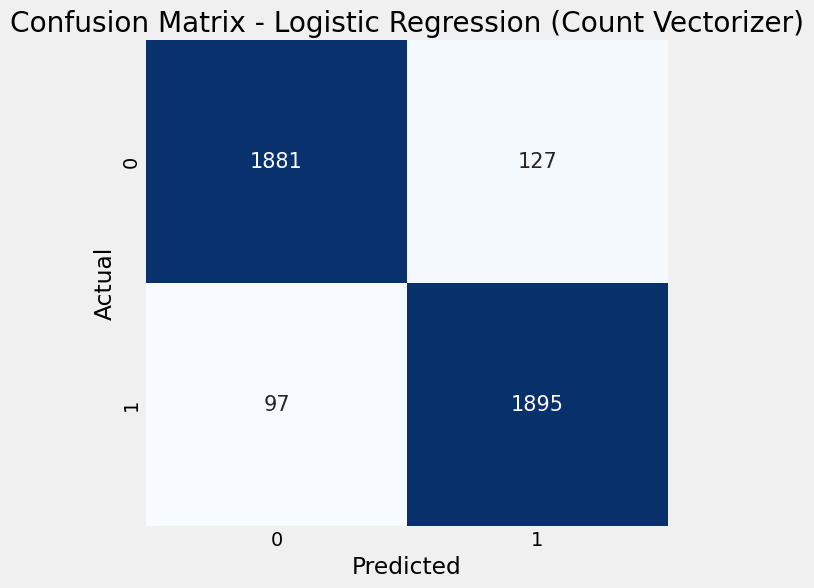

Classification Report - Logistic Regression (Count Vectorizer):
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      2008
           1       0.94      0.95      0.94      1992

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



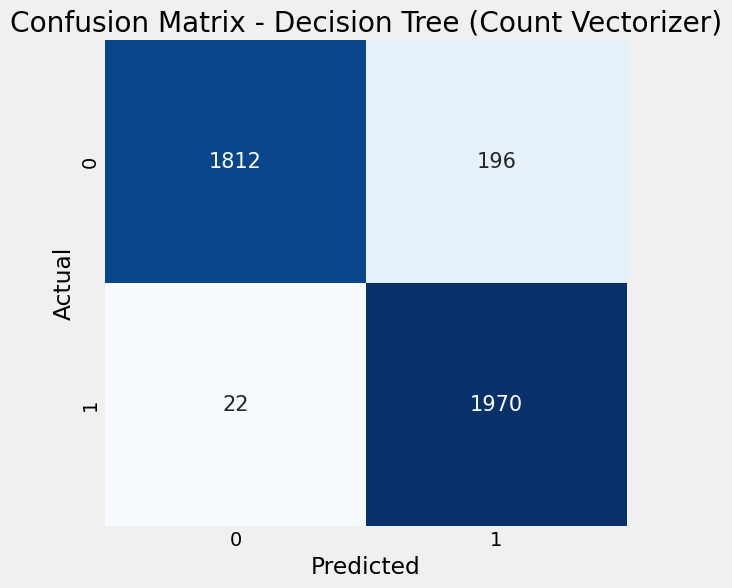

Classification Report - Decision Tree (Count Vectorizer):
               precision    recall  f1-score   support

           0       0.99      0.90      0.94      2008
           1       0.91      0.99      0.95      1992

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



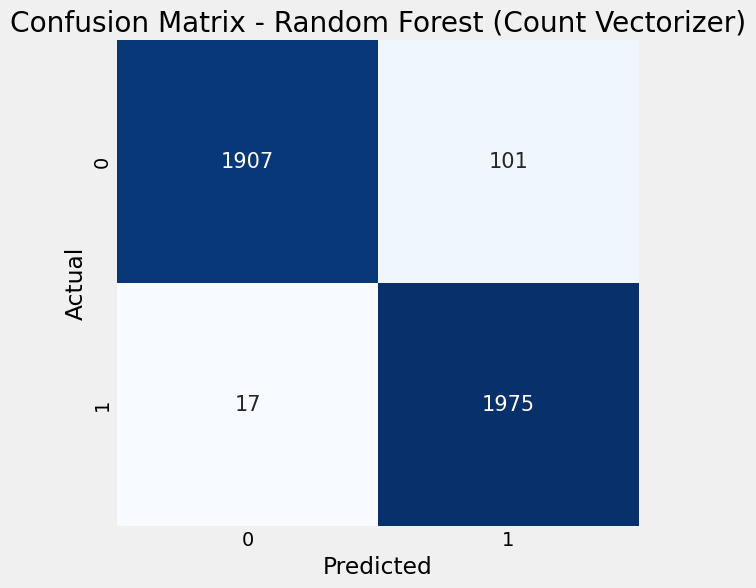

Classification Report - Random Forest (Count Vectorizer):
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      2008
           1       0.95      0.99      0.97      1992

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



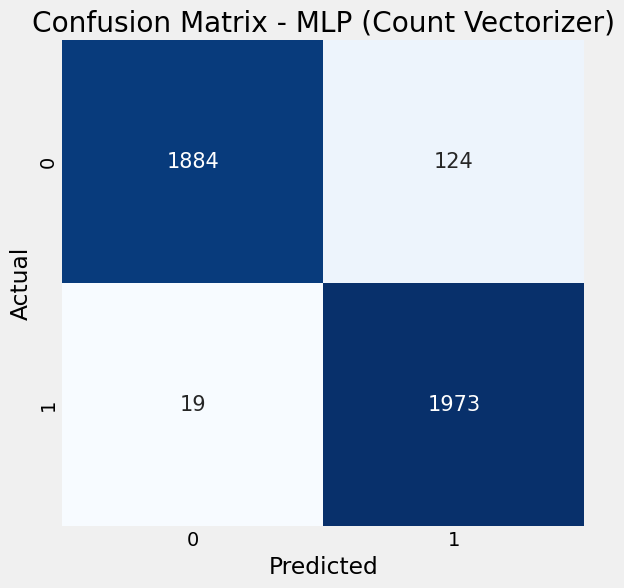

Classification Report - MLP (Count Vectorizer):
               precision    recall  f1-score   support

           0       0.99      0.94      0.96      2008
           1       0.94      0.99      0.97      1992

    accuracy                           0.96      4000
   macro avg       0.97      0.96      0.96      4000
weighted avg       0.97      0.96      0.96      4000



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
# Training and evaluating models
results = {}

for model_name, model in models.items():
    model.fit(X_train_cv, y_train_cv)
    y_pred = model.predict(X_test_cv)
    accuracy = accuracy_score(y_test_cv, y_pred)
    precision = precision_score(y_test_cv, y_pred)
    recall = recall_score(y_test_cv, y_pred)
    f1 = f1_score(y_test_cv, y_pred)
    results[model_name + " (Count Vectorizer)"] = [accuracy, precision, recall, f1]

    # Confusion Matrix
    cm = confusion_matrix(y_test_cv, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15})
    plt.title(f"Confusion Matrix - {model_name} (Count Vectorizer)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print(f"Classification Report - {model_name} (Count Vectorizer):\n", classification_report(y_test_cv, y_pred))

##Model traing on TF-IDF

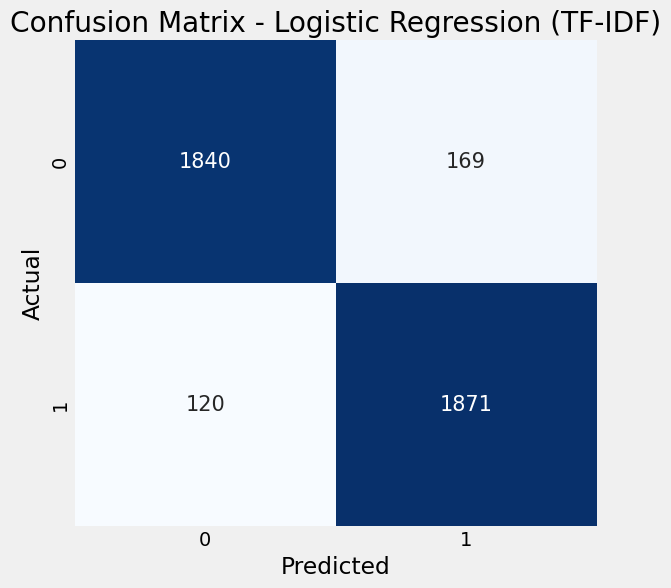

Classification Report - Logistic Regression (TF-IDF):
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      2009
           1       0.92      0.94      0.93      1991

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



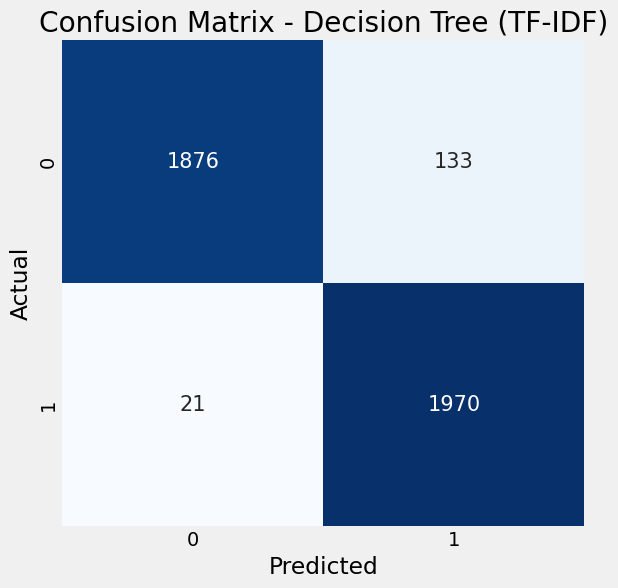

Classification Report - Decision Tree (TF-IDF):
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      2009
           1       0.94      0.99      0.96      1991

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



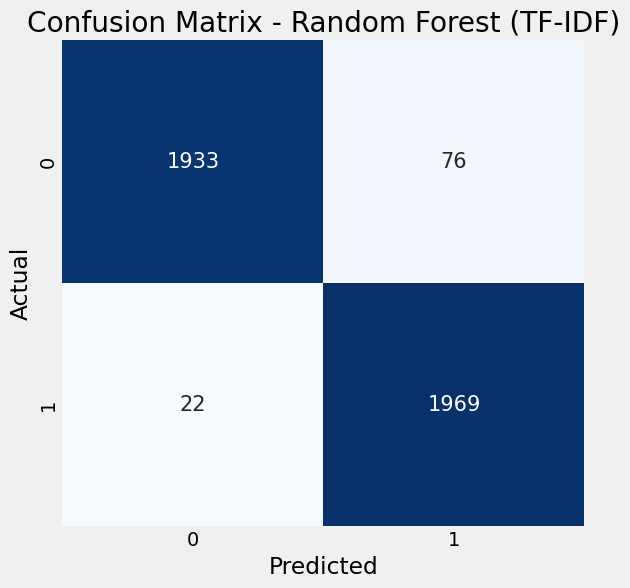

Classification Report - Random Forest (TF-IDF):
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      2009
           1       0.96      0.99      0.98      1991

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



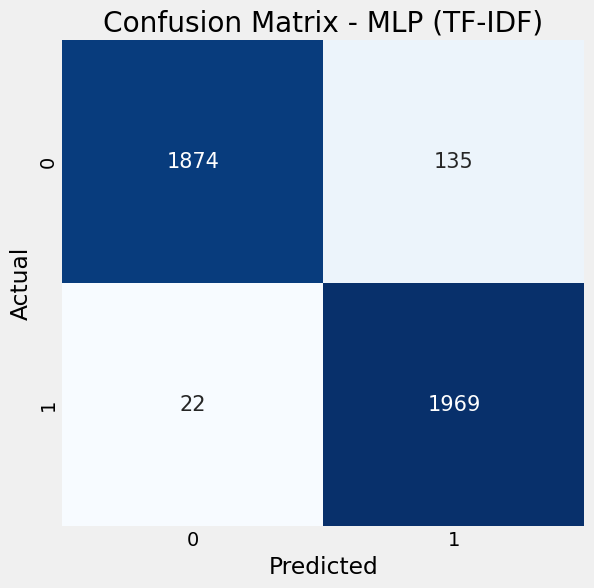

Classification Report - MLP (TF-IDF):
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      2009
           1       0.94      0.99      0.96      1991

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



In [ ]:
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train_tfidf)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test_tfidf, y_pred)
    precision = precision_score(y_test_tfidf, y_pred)
    recall = recall_score(y_test_tfidf, y_pred)
    f1 = f1_score(y_test_tfidf, y_pred)
    results[model_name + " (TF-IDF)"] = [accuracy, precision, recall, f1]

    # Confusion Matrix
    cm = confusion_matrix(y_test_tfidf, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15})
    plt.title(f"Confusion Matrix - {model_name} (TF-IDF)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print(f"Classification Report - {model_name} (TF-IDF):\n", classification_report(y_test_tfidf, y_pred))

## Results comparison

In [ ]:
# Create a DataFrame to display the results
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1 Score"])
results_df

,Logistic Regression (Count Vectorizer),Decision Tree (Count Vectorizer),Random Forest (Count Vectorizer),MLP (Count Vectorizer),Logistic Regression (TF-IDF),Decision Tree (TF-IDF),Random Forest (TF-IDF),MLP (TF-IDF)
Accuracy,0.944000,0.945500,0.970500,0.964250,0.927750,0.961500,0.975500,0.960750
Precision,0.937191,0.909511,0.951349,0.940868,0.917157,0.936757,0.962836,0.935837
Recall,0.951305,0.988956,0.991466,0.990462,0.939729,0.989453,0.988950,0.988950
F1 Score,0.944195,0.947571,0.970993,0.965028,0.928306,0.962384,0.975719,0.961661


## Performance measure comparision

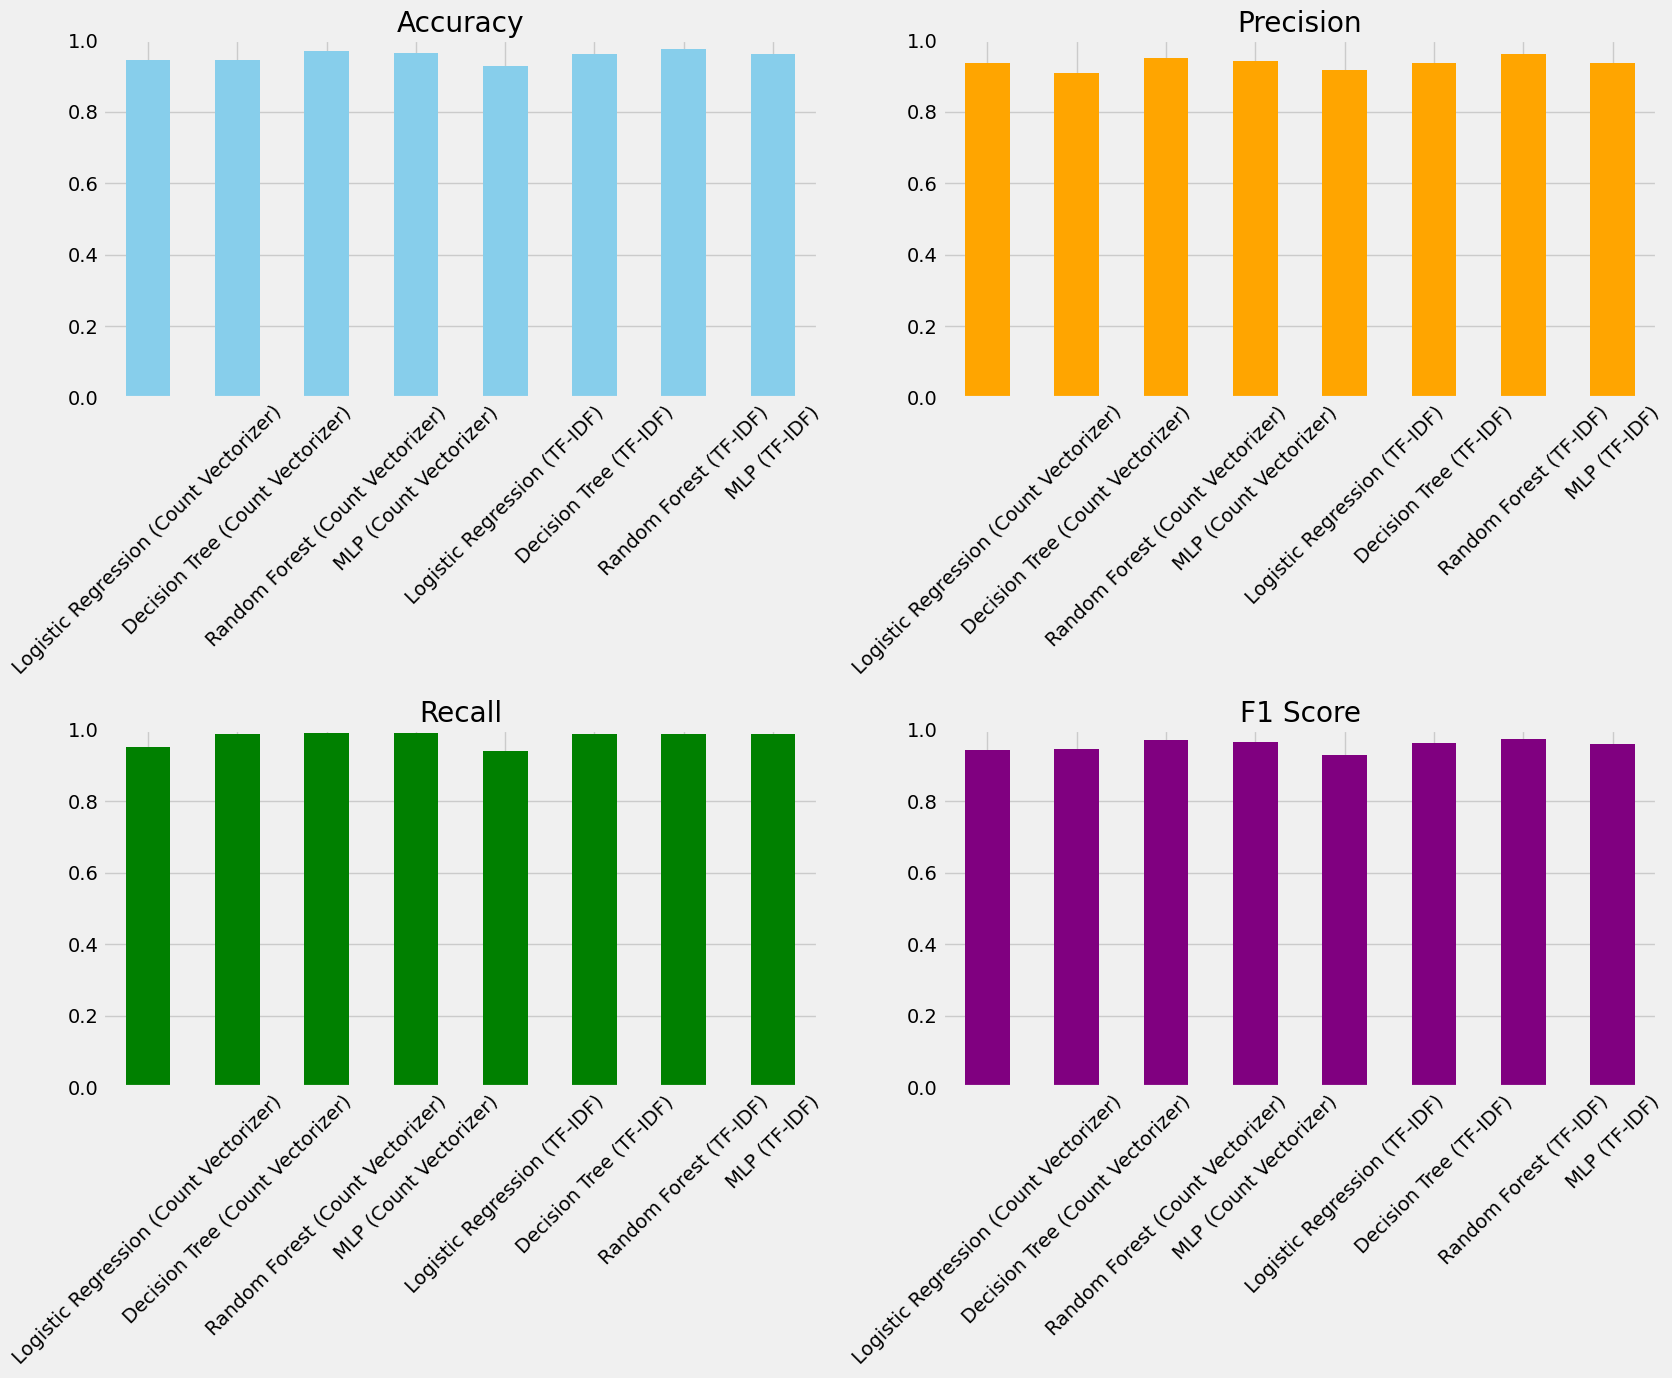

In [ ]:
import matplotlib.pyplot as plt
# Transpose the DataFrame for easier plotting
results_df_transposed = results_df.T

# Plotting the metrics
plt.figure(figsize=(17, 14))

# Accuracy
plt.subplot(2, 2, 1)
results_df_transposed['Accuracy'].plot(kind='bar', color='skyblue')
plt.title('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Precision
plt.subplot(2, 2, 2)
results_df_transposed['Precision'].plot(kind='bar', color='orange')
plt.title('Precision')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Recall
plt.subplot(2, 2, 3)
results_df_transposed['Recall'].plot(kind='bar', color='green')
plt.title('Recall')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# F1 Score
plt.subplot(2, 2, 4)
results_df_transposed['F1 Score'].plot(kind='bar', color='purple')
plt.title('F1 Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


##Model Results Comparison

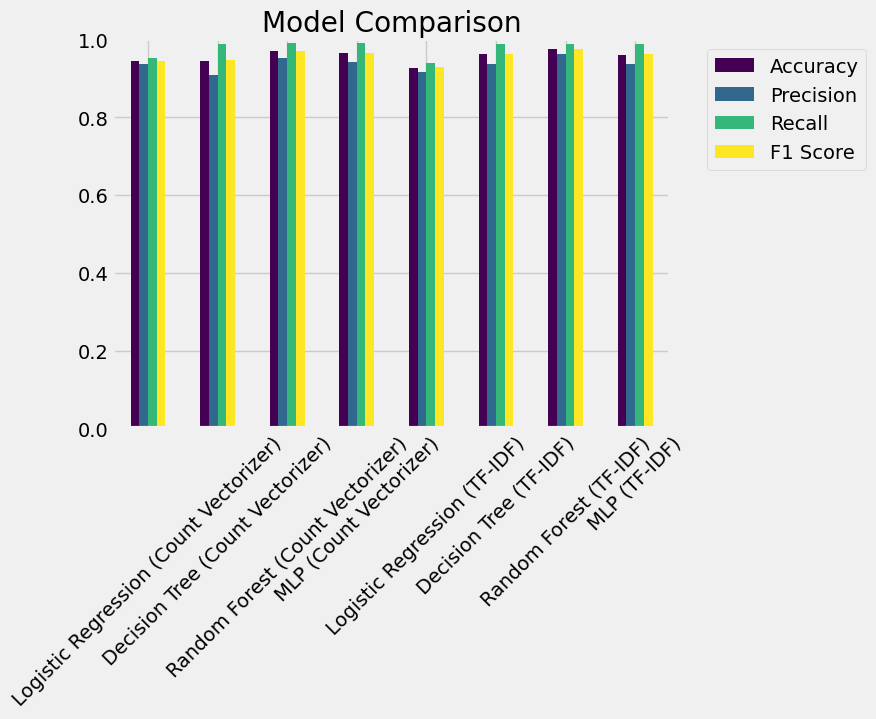

In [ ]:
# Transposing the DataFrame for grouped bar plot
results_df_transposed = results_df.transpose()



# Plotting the metrics
ax = results_df_transposed.plot(kind='bar', colormap='viridis')

# Additional plot customization
ax.set_title('Model Comparison')
ax.set_xticklabels(results_df_transposed.index, rotation=45)
ax.set_ylim(0, 1)

# Place legend outside the plot
ax.legend(["Accuracy", "Precision", "Recall", "F1 Score"], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()